# Location Finding Example

Based on an example from section 6.1 of [this paper](https://arxiv.org/pdf/2103.02438). 

We consider the problem of identifying the location of K hidden, signal emitting sources whose intensity is attenuated by an inverse-square law. The total intensity of the signal is a superposition of the signals from each source. We can locate the K sources by making observations at various locations which is our design variable.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from bed.grid import Grid, GridStack, PermutationInvariant
from bed.design import ExperimentDesigner

## Problem Setup (1D Space, 1 Source)

Define the experimental design space. A "design" in this problem consists of a choice of observation location $x_\text{obs}$ in the same space as the sources. We begin by consider a 1-dimensional space, so our design is 1D.

In [3]:
L = 10 # length of the domain
ngrid = 100 # number of grid points of the designs
designs = Grid(x_obs=np.linspace(0, L, ngrid))

Define the data features. The data consists of a signal measurement $s$ at $x_\text{obs}$. The values we observe are the log of the total intensity, so the Grid is defined over a range of log values.

In [4]:
ngrid = 100 # number of grid points of the designs
features = Grid(s=np.linspace(np.log(0.1), np.log(1.2), ngrid))

Define the parameters, the location of a single source (K=1) in 1D:
- Source location $l_1$

We fix the length of the domain in 1D to match the design space to allow sources over all of the possible design space.

In [5]:
ngrid = 150 # number of grid points of the parameters
params = Grid(l_1=np.linspace(0, L, ngrid))

Tabulate the likelihood $P(s \mid l_1, x_\text{obs})$ for all possible designs $x_\text{obs}$. We assume a Gaussian distribution of measurements with mean $s(x, l)$ and fixed standard deviation $\sigma_s$.

The model $s(x,l)$ has additional parameters $b$ as the base signal for observations far from the sources and $m$ for the max signal when $x=l$.
$\begin{equation}
s(x,l) = b + \sum_{k=1}^K \frac{1}{m + \|x-l\|^2}
\end{equation}$

In [6]:
sigma_s = 0.1 
base_signal = 0.1
max_signal = 1.0
with GridStack(features, designs, params):
    sq_two_norm = np.square(designs.x_obs - params.l_1)
    sq_two_norm_inverse = 1/(max_signal + sq_two_norm)
    s_mean = np.log(base_signal + sq_two_norm_inverse)
    s_diff = features.s - s_mean
    likelihood = np.exp(-0.5 * (s_diff / sigma_s) ** 2)
    features.normalize(likelihood)

Initialize an `ExperimentDesigner` with the grids and likelihood for this problem:

In [7]:
designer = ExperimentDesigner(params, features, designs, likelihood)

## Calculate the Optimal First Measurement (1D Space, 1 Source)

What initial observation location in our 1D design space will provide the most information about the location of the single source? In order to quantify this, via the *expected information gain* (EIG), we must first specify our prior knowledge of the parameters.


Tabulate the prior on our parameters grid which we take to be flat:

In [8]:
prior = np.ones(params.shape)
params.normalize(prior);

Calculate the expected information gain (EIG) for all possible experiment designs (i.e. values of $x_{obs}$):

In [9]:
best = designer.calculateEIG(prior)
designer.describe()

GRID       designs [100:x_obs]
GRID      features [100:s]
GRID    parameters [150:l_1]
ARRAY        prior (150,)                     0.0 Mb
ARRAY   likelihood (100, 100, 150)           11.4 Mb
ARRAY    posterior (100, 100, 150)           11.4 Mb
ARRAY     marginal (100, 100)                 0.1 Mb
ARRAY           IG (100, 100)                 0.1 Mb
ARRAY          EIG (100,)                     0.0 Mb


The `calculateEIG` method returns a dictionary of design variables and their corresponding values where the EIG is maximized. In this case, we just have a single design variable:

In [10]:
best

{'x_obs': 2.929292929292929}

Let's plot the EIG for all possible designs. We see that there are two distinct peaks of equal EIG with a slight difference due to numerical fluctuations. The choice of the left or right peak is arbitrary, either one would be the optimal place to make our first measurement. Regardless of the choice, an observation at this point will allow us to determine if the source exists in the half we make the observation or not.

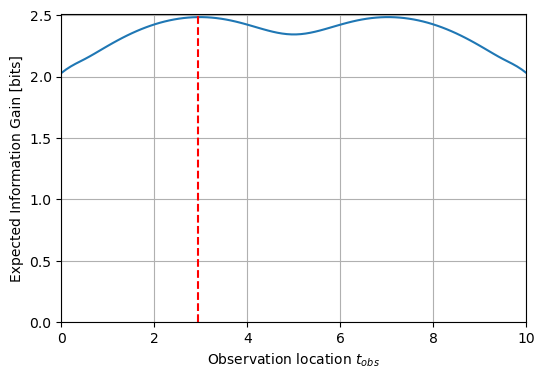

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.x_obs, designer.EIG)
ax.set(xlabel='Observation location $t_{obs}$', xlim=designs.extent('x_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best['x_obs'], color='red', linestyle='--')
ax.grid();

## Calcuate An Optimal Second Measurement

The procedure for calculating subsequent optimal measurements is essentially the same. The only difference is that the original prior is replaced by a posterior probability density on the parameters, conditioned on the measurements taken so far.

Therefore we must specify the location $x_{obs}$ and signal $s$ of the first measurement in order to then calculate an optimal second measurement. Let's assume we make our first measurement at the optimal location $x_{obs} = 2.93$, then how likely are different measurement results $s$? This quantity is already computed and stored as `designer.marginal` for all possible measurement results, and plotted below for $x_{obs} = 2.93$.

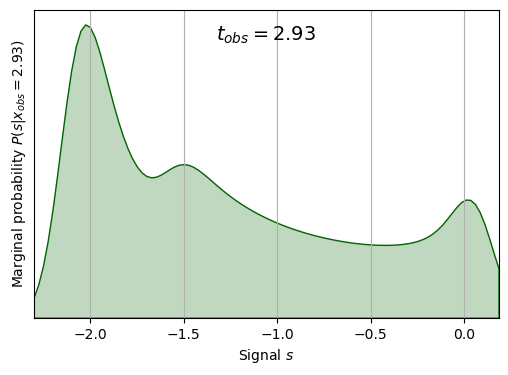

In [12]:
i_best = np.argmax(designer.EIG)
fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(features.s, designer.marginal[:, i_best], ec='#006400', fc='#00640040')
ax.set(xlabel='Signal $s$', xlim=features.extent('s'),
       ylabel=f'Marginal probability $P(s|x_{{obs}}={best["x_obs"]:.2f})$', ylim=(0, None), yticks=[])
ax.text(0.5, 0.9, f'$t_{{obs}}={best["x_obs"]:.2f}$', fontsize=14, transform=ax.transAxes, ha='center')
ax.grid();

Let's assume that our initial measurement at $x_{obs} = 7.07$ yields a signal $s = -1.0$, then the resulting posterior probability density is also already computed and stored as `designer.posterior` for all possible values of $x_{obs}$ and $s$. The plot below compares the (assumed flat) prior with the posterior for our assumed measurement. Note that the posterior is multi-model, i.e. there are two distinct allowed regions in the parameter space.

In [13]:
posterior = designer.get_posterior(x_obs=best['x_obs'], s=-1.0).ravel()
l_1 = params.l_1.ravel()

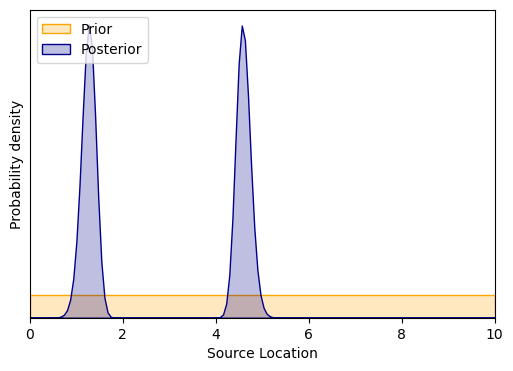

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.fill_between(l_1, prior.ravel(), ec='#FFA500', fc='#FFA50040', label='Prior')
ax.fill_between(l_1, posterior, ec='#00008B', fc='#00008B40', label='Posterior')
ax.set(xlabel='Source Location', xlim=params.extent('l_1'),
       ylabel='Probability density', ylim=(0, None), yticks=[])
ax.legend(loc='upper left');

Finally, to calculate the optimal second (or next) measurement, we call `designer.update` and specify our initial (or previous) measurement:

In [15]:
new_best = designer.update(x_obs=best['x_obs'], s=-1.0)
print(new_best)

{'x_obs': 2.2222222222222223}


The EIG after a 2nd observation shows that there is a dip where the 1st observation was made indicating this would provide less information. This makes sense becuase we already have an idea of what the signal should be near that point.

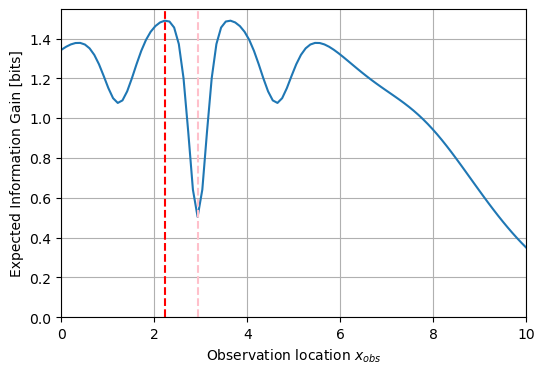

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.x_obs, designer.EIG)
ax.set(xlabel='Observation location $x_{obs}$', xlim=designs.extent('x_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best['x_obs'], color='pink', linestyle='--')
ax.axvline(new_best['x_obs'], color='red', linestyle='--')
ax.grid();

## Problem Setup (1D Space, 2 Sources)

We now consider the same 1D space, but with two sources. This affects the parameter grid and how we define the likelihood.

Define the experimental design space again in the same way.

In [17]:
L = 10 # length of the domain
ngrid = 100 # number of grid points of the designs
designs = Grid(x_obs=np.linspace(0, L, ngrid))

Define the data features almost the same as the single source. However, the key difference is that we must include a higher range of possible values since the signals from each source are added together for the total signal.

In [18]:
ngrid = 100 # number of grid points of the designs
features = Grid(s=np.linspace(np.log(0.1), np.log(2.2), ngrid))

Define the parameters, the locations of each of the two sources (K=2) in 1D:
- First source location $l_1$
- Second source location $l_2$

The two source locations can be permutted without changing the result, i.e. $(l_1, l_2) \equiv (l_2, l_1)$ such that the index of the location doesn't change the result. We can save memory resources by enforcing permutation invariance so that each pair of locations only appears once in the params Grid that we use to calculate the EIG. This can be achieved by setting the `constraint` variable in the Grid class using the `grid.PermutationInvariant` helper function.

In [19]:
ngrid = 150 # number of grid points of the parameters
params = Grid(l_1=np.linspace(0, L, ngrid), l_2=np.linspace(0, L, ngrid), constraint=lambda l_1,l_2: PermutationInvariant(l_1, l_2))

Tabulate the likelihood $P(s \mid l_1, l_2, x_\text{obs})$ for all possible designs $x_\text{obs}$. We assume a Gaussian distribution of measurements with mean $s(x, l)$ and fixed standard deviation $\sigma_s$.

We use eq (1) from above with K=2 to calculate the mean value.

In [20]:
sigma_s = 0.1 
base_signal = 0.1
max_signal = 1.0
with GridStack(features, designs, params):
    sq_two_norm_1 = np.square(designs.x_obs - params.l_1)
    sq_two_norm_2 = np.square(designs.x_obs - params.l_2)
    sq_two_norm_inverse_1 = 1/(max_signal + sq_two_norm_1)
    sq_two_norm_inverse_2 = 1/(max_signal + sq_two_norm_2)
    # sum over the K sources, add base signal and take log.
    sum_two_norm_inverse = sq_two_norm_inverse_1 + sq_two_norm_inverse_2
    s_mean = np.log(base_signal + sum_two_norm_inverse)
    s_diff = features.s - s_mean
    likelihood = np.exp(-0.5 * (s_diff / sigma_s) ** 2)
    features.normalize(likelihood)

Initialize an `ExperimentDesigner` with the grids and likelihood for this problem:

In [21]:
designer = ExperimentDesigner(params, features, designs, likelihood)

## Calculate the Optimal First Measurement (1D Space, 2 Sources)


Tabulate the prior on our parameters grid which we take to be flat:

In [22]:
prior = np.ones(params.shape)
params.normalize(prior);

Calculate the expected information gain (EIG) for all possible experiment designs (i.e. values of $x_{obs}$):

In [23]:
best = designer.calculateEIG(prior)
designer.describe()

GRID       designs [100:x_obs]
GRID      features [100:s]
GRID    parameters [11325:l_1, 11325:l_2]
ARRAY        prior (11325, 1)                 0.1 Mb
ARRAY   likelihood (100, 100, 11325, 1)     864.0 Mb
ARRAY    posterior (100, 100, 11325, 1)     864.0 Mb
ARRAY     marginal (100, 100)                 0.1 Mb
ARRAY           IG (100, 100)                 0.1 Mb
ARRAY          EIG (100,)                     0.0 Mb


Let's plot the EIG for all possible designs. We see that there are two peaks of the same EIG, similar to the result with a single source. However, the peaks are located in slightly different places, closer to the boundaries.

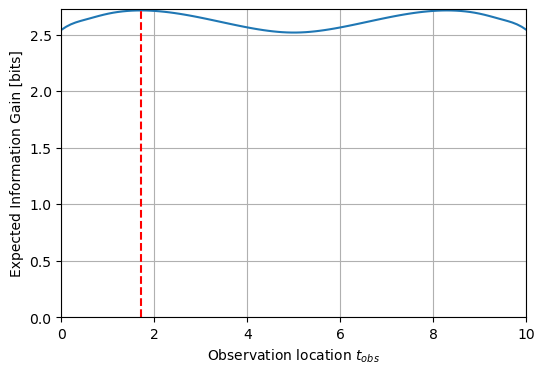

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.x_obs, designer.EIG)
ax.set(xlabel='Observation location $t_{obs}$', xlim=designs.extent('x_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.axvline(best['x_obs'], color='red', linestyle='--')
ax.grid();

We can repeat the same calculation of the marginal distribution and posterior to determine the optimal measurement location of a second design.

## Problem Setup (2D Space, 1 Source)

This same formula used in the likelihood can be extended to higher dimensional space if we consider the designs and parameters to be 2D vectors $(x,y)$.

Since we'll be defining higher dimensional Grids, we decrease the number of points to ensure we don't run into memory issues. We also consider a domain that is defined over a box of size $[10,10]$.

In [25]:
L = 10 # length of the domain
ngrid = 50 # number of grid points of the designs
designs = Grid(x_obs=np.linspace(0, L, ngrid), y_obs=np.linspace(0, L, ngrid))

The data features remains unchanged in the 2D space with a single source since the only difference is in how we calculate the distance between source and observation point. 

In [26]:
ngrid = 100 # number of grid points of the designs
features = Grid(s=np.linspace(np.log(0.1), np.log(1.2), ngrid))

Define the parameters, the location of a single source (K=1) in 2D:
- Source location in x dimension $l_{x_1}$
- Source location in y dimension $l_{y_1}$

We fix the length of the domain in 2D to match the design space to allow sources over all of the possible design space.

In [27]:
ngrid = 75 # number of grid points of the parameters
params = Grid(l_x1=np.linspace(0, L, ngrid), l_y1=np.linspace(0, L, ngrid))

Tabulate the likelihood $P(s \mid l_{x_1}, l_{y_1}, x_\text{obs}, y_\text{obs})$ for all possible designs $x_\text{obs}$. We assume a Gaussian distribution of measurements with mean $s(x, y, l_{x_1}, l_{y_1})$ and fixed standard deviation $\sigma_s$.

In [28]:
sigma_s = 0.1 
base_signal = 0.1
max_signal = 1.0
with GridStack(features, designs, params):
    sq_two_norm = np.square(designs.x_obs - params.l_x1) + np.square(designs.y_obs - params.l_y1)
    sq_two_norm_inverse = 1/(max_signal + sq_two_norm)
    s_mean = np.log(base_signal + sq_two_norm_inverse)
    s_diff = features.s - s_mean
    likelihood = np.exp(-0.5 * (s_diff / sigma_s) ** 2)
    features.normalize(likelihood)

Initialize an `ExperimentDesigner` with the grids and likelihood for this problem:

In [29]:
designer = ExperimentDesigner(params, features, designs, likelihood)

## Calculate the Optimal First Measurement (2D Space, 1 Source)

Tabulate the prior on our parameters grid which we take to be flat:

In [30]:
prior = np.ones(params.shape)
params.normalize(prior);

Calculate the expected information gain (EIG) for all possible experiment designs (i.e. values of $(x_{obs}, y_{obs})$):

In [31]:
best = designer.calculateEIG(prior)
designer.describe()

GRID       designs [50:x_obs, 50:y_obs]
GRID      features [100:s]
GRID    parameters [75:l_x1, 75:l_y1]
ARRAY        prior (75, 75)                   0.0 Mb
ARRAY   likelihood (100, 50, 50, 75, 75)  10728.8 Mb
ARRAY    posterior (100, 50, 50, 75, 75)  10728.8 Mb
ARRAY     marginal (100, 50, 50)              1.9 Mb
ARRAY           IG (100, 50, 50)              1.9 Mb
ARRAY          EIG (50, 50)                   0.0 Mb


Let's plot the EIG for all possible designs. Similar to the 1D space where we had two peaks located in each half of the domain, the 2D space shows four peaks located in each quadrant. The red dot shows the location of maximum EIG corresponding to the optimal place to make a measurement. This value could have been at one of the three other peaks with the only difference between peaks being due to numerical fluctuations.

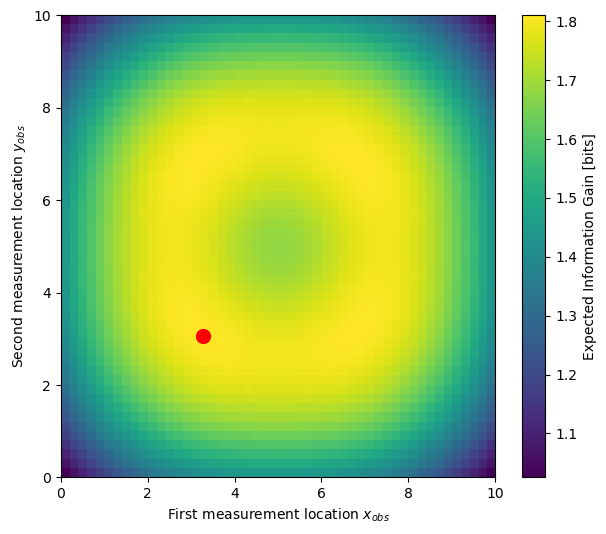

In [32]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer.EIG.T, origin='lower', extent=designs.extent('x_obs')+designs.extent('y_obs'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot(best['x_obs'], best['y_obs'], 'ro', markersize=10)
ax.set(xlabel='First measurement location $x_{obs}$', ylabel='Second measurement location $y_{obs}$');

## Problem Setup (2D Space, 2 Sources)

For our final variation of the location finding problem, we consider a 2D space over which our sources are located and allow for two different sources to produce a total signal.

We define the same design grid as in the 2D, single source problem.

In [33]:
L = 10 # length of the domain
ngrid = 20 # number of grid points of the designs
designs = Grid(x_obs=np.linspace(0, L, ngrid), y_obs=np.linspace(0, L, ngrid))

The data features remain as a single dimensional Grid, but with an increased upper limit given that the signal of two sources sum together as in eq (1).

In [34]:
ngrid = 100 # number of grid points of the designs
features = Grid(s=np.linspace(np.log(0.1), np.log(2.2), ngrid))

Define the parameters, the locations of each of the two sources (K=2) in 1D:
- First source location in x dimension $l_{x_1}$
- First source location in y dimension $l_{y_1}$
- Second source location in x dimension $l_{x_2}$
- Second source location in y dimension $l_{y_2}$

Like in the 1D space, the two source locations can be permutted without changing the result. Again, we apply the `grid.PermutationInvariant` helper function as a `constraint` to the params Grid. We only need to apply the permutation invariance on one of the spatial dimensions to ensure we aren't repeating pairs of locations. That way all values of the other dimension are still allowed without any single pair being repeated.

In [35]:
ngrid = 20 # number of grid points of the parameters
params = Grid(l_x1=np.linspace(0, L, ngrid), l_y1=np.linspace(0, L, ngrid), l_x2=np.linspace(0, L, ngrid), l_y2=np.linspace(0, L, ngrid), constraint=lambda l_x1,l_x2: PermutationInvariant(l_x1, l_x2))

Tabulate the likelihood $P(s \mid l_{x_1}, l_{y_1}, l_{x_2}, l_{y_2}, x_\text{obs}, y_\text{obs})$ for all possible designs $(x_\text{obs}, y_\text{obs})$. We assume a Gaussian distribution of measurements with mean $s(x, y, l_{x_1}, l_{y_1},l_{x_2}, l_{y_2})$ and fixed standard deviation $\sigma_s$. In this case, the likelihood is now a 7D object, so we have to make sure our number of grid points aren't too large for each of params, features, and designs.

In [36]:
sigma_s = 0.1 
base_signal = 0.1
max_signal = 1.0
with GridStack(features, designs, params):
    # compute the squared two norm between the observation and the source
    sq_two_norm_1 = np.square(designs.x_obs - params.l_x1) + np.square(designs.y_obs - params.l_y1)
    sq_two_norm_2 = np.square(designs.x_obs - params.l_x2) + np.square(designs.y_obs - params.l_y2)
    # compute the inverse of the squared two norm plus a constant 
    sq_two_norm_inverse_1 = 1/(max_signal + sq_two_norm_1)
    sq_two_norm_inverse_2 = 1/(max_signal + sq_two_norm_2)
    # sum over the K sources, add base signal and take log.
    sum_two_norm_inverse = sq_two_norm_inverse_1 + sq_two_norm_inverse_2
    s_mean = np.log(base_signal + sum_two_norm_inverse)
    
    # convert the signal to the likelihood
    s_diff = features.s - s_mean
    likelihood = np.exp(-0.5 * (s_diff / sigma_s) ** 2)
    features.normalize(likelihood)

Initialize an `ExperimentDesigner` with the grids and likelihood for this problem:

In [37]:
designer = ExperimentDesigner(params, features, designs, likelihood)

## Calculate the Optimal First Measurement (2D Space, 2 Sources)

Tabulate the prior on our parameters grid which we take to be flat:

In [38]:
prior = np.ones(params.shape)
params.normalize(prior);

Calculate the expected information gain (EIG) for all possible experiment designs (i.e. values of $(x_{obs}, y_{obs})$):

In [39]:
best = designer.calculateEIG(prior)
designer.describe()

GRID       designs [20:x_obs, 20:y_obs]
GRID      features [100:s]
GRID    parameters [210:l_x1, 20:l_y1, 210:l_x2, 20:l_y2]
ARRAY        prior (210, 20, 1, 20)           0.6 Mb
ARRAY   likelihood (100, 20, 20, 210, 20, 1, 20) 25634.8 Mb
ARRAY    posterior (100, 20, 20, 210, 20, 1, 20) 25634.8 Mb
ARRAY     marginal (100, 20, 20)              0.3 Mb
ARRAY           IG (100, 20, 20)              0.3 Mb
ARRAY          EIG (20, 20)                   0.0 Mb


By enforcing permutation invariance, we've decreased the memory usage of the likelihood and posterior by almost half!

Let's plot the EIG for all possible designs. Since we had to use a more coarse Grid for the design grid, the EIG plot is less smooth. The form of the distribution matches what we found in the 2D, single source problem where there are four equal peaks located in each quadrant of the domain. One of the peaks chosen as the best is represented by the red dot on the plot.

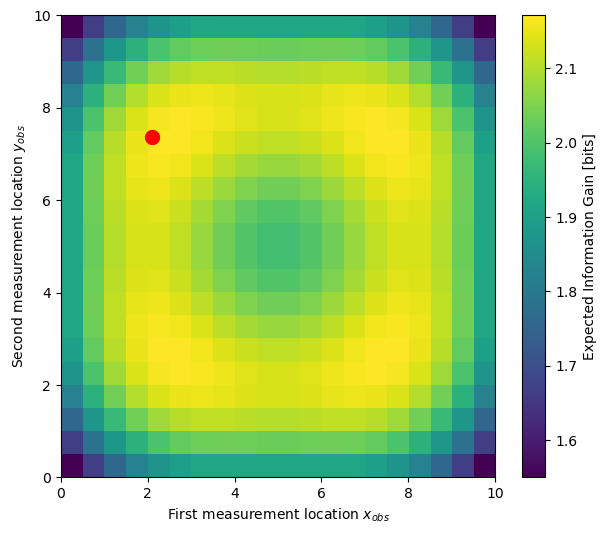

In [40]:
fig, ax = plt.subplots(figsize=(7,6))
I = ax.imshow(designer.EIG.T, origin='lower', extent=designs.extent('x_obs')+designs.extent('y_obs'), aspect='auto')
plt.colorbar(I, ax=ax, label='Expected Information Gain [bits]')
ax.plot(best['x_obs'], best['y_obs'], 'ro', markersize=10)
ax.set(xlabel='First measurement location $x_{obs}$', ylabel='Second measurement location $y_{obs}$');